Track reconstruction made easy
==============================

This is a pet project to do track reconstruction,
based on real data coming from the LHCb detector at CERN.

Think you can make it better? Go ahead and try!

What is track reconstruction?
-----------------------------

At the LHCb detector, millions of particles collide at speeds
close to the speed of light, leaving traces (hits) on the sensors
placed in their way.

The collisions that happen at the same time are packed
into an *event*, and sent to one of our servers,
that must reconstruct the tracks that formed each particle
in real time.

This project contains events in json format. These events are
then processed by some reconstruction algorithm, and finally
the results are validated. That is, the particles found by
the solver are matched against the real particles that came out of
the collisions in the event.

![velopix reconstruction example](reco_example.png "velopix reconstruction example")

Diving into details
-------------------

Input files are specified in json. An *event model* to parse them
is shipped with this project.

In [0]:
import event_model as em
import json
f = open("velojson/1.json")
json_data = json.loads(f.read())
event = em.event(json_data)
f.close()

The LHCb Velopix detector has 52 modules. Spread across the modules,
we should have many hits, depending on the event we are on.

In [7]:
print(len(event.modules))
print(len(event.hits))

52
3366


Hits are composed of an ID, and {x, y, z} coordinates.

In [8]:
print(event.hits[0])

#0 id 44897 module 0 {-9.821713, 29.362608, -275.531006}


Modules are placed at some z in the detector. Each module
may have as many hits as particles crossed by it, plus some noise to
make things interesting.

In [0]:
print(event.modules[0])

Visually, the data looks like this:

In [0]:
from visual.base import print_event_2d
%matplotlib inline

print_event_2d(event)
print_event_2d(event, y=1)

A tracking algorithm solution
----------------

A simplistic implementation runs through all sensors sequentially,
finding tracks by matching hits in a straight line.

In [0]:
from search_by_triplet_trie import search_by_triplet_trie
tracks = search_by_triplet_trie().solve(event)

print(len(tracks))
print(tracks[0])

Finally, we should validate these results, and we'll look
at three things:
    
*   Reconstruction Efficiency: The fraction of real particles we have reconstructed.
    > \# correctly reconstructed / \# real tracks

*   Clone Tracks: Tracks that are similar to other correctly reconstructed tracks.
    > \# clone tracks / \# correctly reconstructed

*   Fake Tracks: Tracks that are incorrect, either created by noise or by incorrectly reconstructing a track.
    > \# incorrectly reconstructed / \# all reconstructed

We will get the validation detailed for different kinds of particles.

In [0]:
import validator_lite as vl
vl.validate_print([json_data], [tracks])

And visually, we can see what our solution looks like:

In [20]:
dir(event.modules[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_module__global_hits',
 'hit_end_index',
 'hit_start_index',
 'hits',
 'module_number',
 'z']

In [0]:
print_event_2d(event, tracks=tracks)
print_event_2d(event, tracks=tracks, y=1)

Data analysis exercises
---------------

We will just try to understand how the data of the problem looks like. Produce a plot with:

* X axis: Module number
* Y axis: Number of hits in the module

Usually, algorithms start looking at data from the last module, because the number of hits is lower there. Is this true?

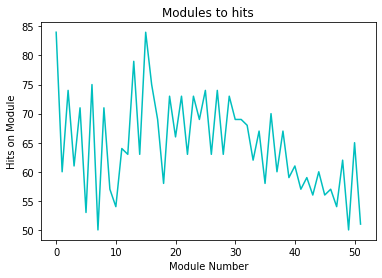

In [23]:
import numpy as np
import matplotlib.pyplot as plt
numMod = len(event.modules)
x = np.arange (0, numMod, 1)
y = []
for i in range(numMod):
  y.append(len(event.modules[i].hits()))

plt.figure()
plt.plot(x,y,'c')
plt.xlabel("Module Number")
plt.ylabel("Hits on Module")
plt.title("Modules to hits")
plt.show()

The technique used in the above solution, named "search_by_triplet_trie", finds triplets of hits in neighbouring modules on the same side. Odd modules are placed on the left, whereas even modules are placed on the right.

* Fetch all hits in a numpy array. Use a selector to iterate over the hits on modules on either side.
* Plot the number of pairs of hits in every consecutive pair of modules on the same side.
* Plot the number of triplets of hits in every consecutive triplet of modules on the same side.

<Figure size 432x288 with 0 Axes>

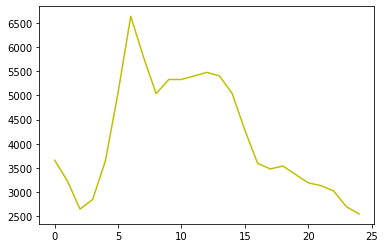

<Figure size 432x288 with 0 Axes>

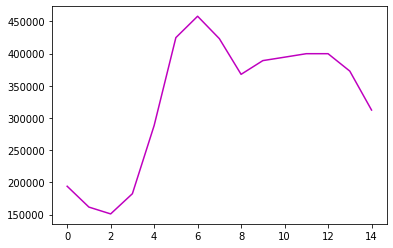

In [54]:
Hits = []
for  i in range(numMod):
  Hits.append(event.modules[i].hits())
Hits = np.array(Hits)

Module=[]
for i in range(numMod):
  Module.append(event.modules[i])
Module = np.array(Module)

mskEven = [bool(i % 2) for i in range(numMod)]
mskOdd = [bool ((i+1)%2) for i in range(numMod)]

hmod= int((numMod/2))

even = Module[mskEven]
odd = Module[mskOdd]


a = []
b = np.arange(0, hmod-1, 1)
for i in range(hmod-1):
  a.append(len(even[i].hits()) * len(even[i+1].hits()))

plt.figure()
plt.show()
plt.plot(b,a,'y')

tmod = int(numMod/3)

c = []
d = np.arange(0, tmod-2, 1)
for i in range(tmod-2):
  c.append(len(even[i].hits())*len(even[i+1].hits())*len(even[i+2].hits()))

plt.figure()
plt.show()
plt.plot(d, c, 'm')


"search_by_triplet_trie" obtains many tracks, aka collections of signals left in the detector by particles. We would like to know the goodness of these tracks:

* Iterate over the tracks from the solution. Print for every track hits its X, Y and Z coordinates.
* Create a means_squared_error method that gets a track as an input and calculates the MSE (https://en.wikipedia.org/wiki/Mean_squared_error) of a track.
* The above algorithm gets a high fake rate, and this is most likely due to tracks with a high MSE. Make a track filter to remove the bad tracks and pass that to the validator.

In [55]:
from search_by_triplet_trie import search_by_triplet_trie
tracks = search_by_triplet_trie().solve(event)

print(len(tracks))
print(tracks[0])

463
Track hits #4: [#3261 id 52551389 module 50 {-2.782467, 12.678425, 749.468994}, #3152 id 50468051 module 48 {-0.215669, 10.889446, 699.468994}, #3044 id 48385223 module 46 {2.448358, 9.158798, 649.468994}, #2931 id 46302650 module 44 {5.170717, 7.447601, 599.468994}]


In [65]:
print(tr)

TypeError: ignored